### This notebook reviews the test cases that I'm using to debug the Beaching Time Scale values in open ocean.  They include:
1. Original Test
2. Test with OilType set to Crude
3. Test with Emulsification turned on [Mackay]
4. Test with Gasoline Lagrangian file


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.dates as mpd
import cmocean as cm
import glob
import os
import xarray as xr
import datetime
from salishsea_tools import viz_tools, tidetools, geo_tools, gsw_calls, wind_tools
import pickle
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sys import platform

%matplotlib inline

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
## User inputs.  As set up now, darwin -> paths on Rachael's "shuga" laptop 
## The other paths are for Vicky's Ocean setup

if platform == 'darwin':
    bathy_dir = '/Users/rmueller/Data/SalishSeaCast/grid/'
    results_dir = '/Users/rmueller/Projects/'
    out_dir = '/Users/rmueller/Documents/Presentations/2020/OceanSciences2020/'
else:
    bathy_dir = '/data/vdo/MEOPAR/NEMO-forcing/grid/'
    results_dir = '/ocean/vdo/'
    out_dir = '/home/vdo/'
    
# Set to [1] if you want to print to file and [0] if not
print_to_file = 1  

In [4]:
## User inputs.  As set up now, darwin -> paths on Rachael's "shuga" laptop 
## The other paths are for Vicky's Ocean setup

if platform == 'darwin':
    bathy_dir = '/Users/rmueller/Data/SalishSeaCast/grid/'
    results_dir = '/Users/rmueller/Projects/'
else:
    bathy_dir = '/data/vdo/MEOPAR/NEMO-forcing/grid/'
    results_dir = '/ocean/vdo/'

In [5]:
## colourmap for the land/water. 
#vmax = 1
#cmap2 = LinearSegmentedColormap.from_list('mycmap', [(0 / vmax, 'lightskyblue'), #change this if you want a different colour for water
#                                                    (0.85 / vmax, 'lightskyblue'), #change this if you want a different colour for water
#                                                    (0.850001 / vmax, 'papayawhip'), #change this if you want a different colour for land
#                                                    (1 / vmax, 'papayawhip')] #change this if you want a different colour for land
#                                        )

In [6]:
# load data
# Note: The filename says SOG but the results show that it's not an SOG location
#bunker = nc.Dataset(results_dir + 'MIDOSS/results/HeavyFloater/SOG_21nov17-28nov17_general_evap_fix2/Lagrangian_BunkerC_crude_SOG_21nov17-28nov17.nc')
#diesel = nc.Dataset(results_dir + 'MIDOSS/results/OS2020/diesel/SB/Lagrangian_DieselFuel_refined_21nov17-28nov17_Diesel.nc')

diesel = xr.open_dataset(results_dir + 'MIDOSS/results/LightEvaporator/BeachingTimeScaleTests/Diesel/Lagrangian_DieselFuel_refined_21nov17-28nov17_original.nc')
diesel_crude = xr.open_dataset(results_dir + 'MIDOSS/results/LightEvaporator/BeachingTimeScaleTests/Diesel/Lagrangian_DieselFuel_Crude_SB_21nov2017_28nov2017.nc')
diesel_emuls = xr.open_dataset(results_dir + 'MIDOSS/results/LightEvaporator/BeachingTimeScaleTests/Diesel/Lagrangian_DieselFuel_refined_SB_21nov2017_28nov2017_Emulsification.nc')
diesel_evap  = xr.open_dataset(results_dir + 'MIDOSS/results/LightEvaporator/BeachingTimeScaleTests/Diesel/Lagrangian_DieselFuel_refined_SB_21nov2017_28nov2017_EvapExposure.nc')
gas = xr.open_dataset(results_dir + '/MIDOSS/results/LightEvaporator/BeachingTimeScaleTests/gas/Lagrangian_Gasoline_refined_SB_21nov2017_28nov2017.nc')
jet = xr.open_dataset(results_dir + '/MIDOSS/results/LightEvaporator/BeachingTimeScaleTests/jet/Lagrangian_JetFuel_refined_SB_21nov2017_28nov2017.nc')
gas_fingas = xr.open_dataset(results_dir + '/MIDOSS/results/LightEvaporator/BeachingTimeScaleTests/gas/Lagrangian_Gasoline_refined_SB_21nov2017_28nov2017_fingas.nc')

#bt_diesel = diesel.variables['Beaching_Time'][:] # This is if using nc.Dataset for reading in values
diesel_time = diesel.Beaching_Time[:]
diesel_crude_time = diesel_crude.Beaching_Time[:]
diesel_emuls_time = diesel_emuls.Beaching_Time[:]
diesel_evap_time  = diesel_evap.Beaching_Time[:]
gas_time = gas.Beaching_Time[:]


In [26]:
# The following are a set of tests that I did by copying and pasting values from Jet Fuel into the Diesel Lagrangian file to test
# (1) Biodegredation coefficients, (2) Fixed Biodegredation coefficients (3) API and that grouping, (4) OW interfacial tension
diesel_jetbiocoefs = xr.open_dataset(results_dir + 'MIDOSS/results/LightEvaporator/BeachingTimeScaleTests/Diesel/Lagrangian_DieselFuel_refined_SB_21nov2017_28nov2017_JetBio.nc')
diesel_jetbio_time = diesel_jetbiocoefs.Beaching_Time[:]

diesel_biofixed = xr.open_dataset(results_dir + 'MIDOSS/results/LightEvaporator/BeachingTimeScaleTests/Diesel/Lagrangian_DieselFuel_refined_SB_21nov2017_28nov2017_Biofixed.nc')
diesel_biofixed_time = diesel_biofixed.Beaching_Time[:]

In [7]:
gas_fingas_time = gas_fingas.Beaching_Time[:]
jet_time = jet.Beaching_Time[:]

In [8]:
#~~~~~ NEED TO UPDATE THIS TO AUTOMATE START_TIME DEFINITION FOR MORE GENERAL APPLICATION  ~~~~~~~~~
start_time = np.datetime64('2017-11-21T00:30:00')
start_time

numpy.datetime64('2017-11-21T00:30:00')

In [9]:
# get size of array 
[ny,nx] = diesel_time.shape
ny

896

In [10]:
x_range = range(nx)
y_range = range(ny)
y_range

range(0, 896)

In [11]:
# get diesel time as numeric value
display('Calculating diesel (original) time')
diesel_time_asnum = np.array([[((np.datetime64(diesel_time.values[jj,ii]) - start_time) / np.timedelta64(1, 'D')) for ii in x_range] for jj in y_range])

'Calculating diesel (original) time'

In [12]:
display('Calculating diesel (crude) time')
diesel_crude_time_asnum = np.array([[((np.datetime64(diesel_crude_time.values[jj,ii])- start_time) / np.timedelta64(1, 'D')) for ii in x_range] for jj in y_range])

'Calculating diesel (crude) time'

In [13]:
display('Calculating diesel (emulsification) time')
diesel_emuls_time_asnum = np.array([[((np.datetime64(diesel_emuls_time.values[jj,ii])- start_time) / np.timedelta64(1, 'D')) for ii in x_range] for jj in y_range])

'Calculating diesel (emulsification) time'

In [14]:
display('Calculating diesel (evaporation) time')
diesel_evap_time_asnum = np.array([[((np.datetime64(diesel_evap_time.values[jj,ii])- start_time) / np.timedelta64(1, 'D')) for ii in x_range] for jj in y_range])

'Calculating diesel (evaporation) time'

In [15]:
display('Calculating jet time')
jet_time_asnum = np.array([[((np.datetime64(jet_time.values[jj,ii])- start_time) / np.timedelta64(1, 'D')) for ii in x_range] for jj in y_range])

'Calculating jet time'

In [16]:
display('Calculating gas time')
gas_time_asnum = np.array([[((np.datetime64(gas_time.values[jj,ii])- start_time) / np.timedelta64(1, 'D')) for ii in x_range] for jj in y_range])

'Calculating gas time'

In [17]:
display('Calculating gas (fingas) time')
gas_fingas_time_asnum = np.array([[((np.datetime64(gas_fingas_time.values[jj,ii])- start_time) / np.timedelta64(1, 'D')) for ii in x_range] for jj in y_range])

'Calculating gas (fingas) time'

In [27]:
# get diesel time as numeric value
display('Calculating diesel (biocoefs) time')
diesel_jetbio_time_asnum = np.array([[((np.datetime64(diesel_jetbio_time.values[jj,ii]) - start_time) / np.timedelta64(1, 'D')) for ii in x_range] for jj in y_range])

'Calculating diesel (biocoefs) time'

In [28]:
# get diesel time as numeric value
display('Calculating diesel (biocoefs) time')
diesel_biofixed_time_asnum = np.array([[((np.datetime64(diesel_biofixed_time.values[jj,ii]) - start_time) / np.timedelta64(1, 'D')) for ii in x_range] for jj in y_range])

'Calculating diesel (biocoefs) time'

In [19]:
start_time

numpy.datetime64('2017-11-21T00:30:00')

In [20]:
# set zero values to NaN
diesel_time_asnum[diesel_time_asnum==0] = np.nan
diesel_crude_time_asnum[diesel_crude_time_asnum==0] = np.nan
diesel_emuls_time_asnum[diesel_emuls_time_asnum==0] = np.nan
diesel_evap_time_asnum[diesel_evap_time_asnum==0] = np.nan
gas_time_asnum[gas_time_asnum==0] = np.nan
jet_time_asnum[jet_time_asnum==0] = np.nan
gas_fingas_time_asnum[gas_fingas_time_asnum==0] = np.nan

In [29]:
diesel_jetbio_time_asnum[diesel_jetbio_time_asnum==0] = np.nan
diesel_biofixed_time_asnum[diesel_biofixed_time_asnum==0] = np.nan

'dark_background'

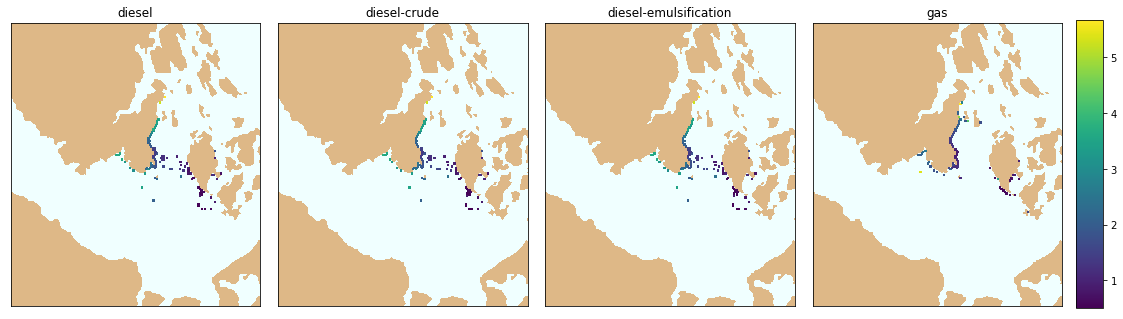

In [21]:
fig, axs = plt.subplots(1,4,figsize=(15,5))

# add land mask to ax1 and ax2
viz_tools.plot_land_mask(axs[0],'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')
viz_tools.plot_land_mask(axs[1],'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')
viz_tools.plot_land_mask(axs[2],'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')
viz_tools.plot_land_mask(axs[3],'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')

# add beaching time scales
mappable = axs[0].pcolormesh(diesel_time_asnum)
mappable = axs[1].pcolormesh(diesel_crude_time_asnum)
mappable = axs[2].pcolormesh(diesel_emuls_time_asnum)
mappable = axs[3].pcolormesh(gas_time_asnum)

axs[0].set_title("diesel")
axs[1].set_title("diesel-crude")
axs[2].set_title("diesel-emulsification")
axs[3].set_title("gas")

for a in axs:
    a.set_facecolor('azure')
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
    viz_tools.set_aspect(a)
    a.set_xlim(100,300) #change this to set x axis limits
    a.set_ylim(200,400) #change this to set y axis limits
    
plt.tight_layout();

#[left, bottom, width, height]
ax_cbar = fig.add_axes([1.,0.1,0.025,.8])
cbar = plt.colorbar(mappable, cax=ax_cbar, orientation='vertical')
plt.style.available[23]

'dark_background'

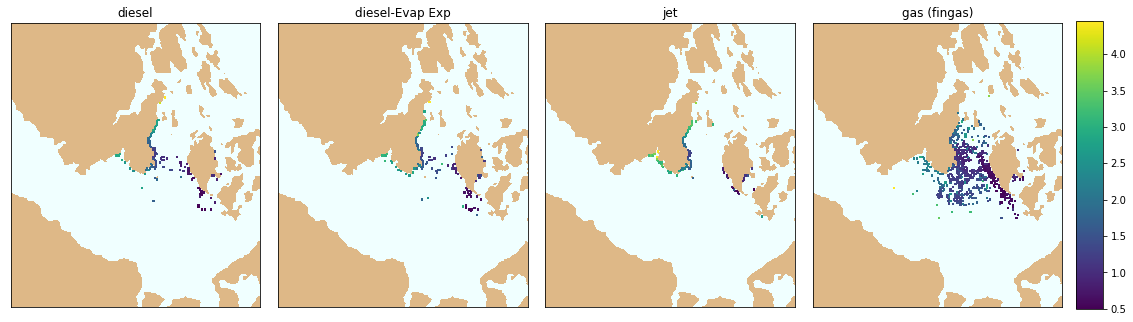

In [22]:
fig, axs = plt.subplots(1,4,figsize=(15,5))

# add land mask to ax1 and ax2
viz_tools.plot_land_mask(axs[0],'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')
viz_tools.plot_land_mask(axs[1],'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')
viz_tools.plot_land_mask(axs[2],'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')
viz_tools.plot_land_mask(axs[3],'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')

# add beaching time scales
mappable = axs[0].pcolormesh(diesel_time_asnum)
mappable = axs[1].pcolormesh(diesel_evap_time_asnum)
mappable = axs[2].pcolormesh(jet_time_asnum)
mappable = axs[3].pcolormesh(gas_fingas_time_asnum)

axs[0].set_title("diesel")
axs[1].set_title("diesel-Evap Exp")
axs[2].set_title("jet")
axs[3].set_title("gas (fingas)")


for a in axs:
    a.set_facecolor('azure')
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
    viz_tools.set_aspect(a)
    a.set_xlim(100,300) #change this to set x axis limits
    a.set_ylim(200,400) #change this to set y axis limits
    
plt.tight_layout();

#[left, bottom, width, height]
ax_cbar = fig.add_axes([1.,0.1,0.025,.8])
cbar = plt.colorbar(mappable, cax=ax_cbar, orientation='vertical')
plt.style.available[23]

'dark_background'

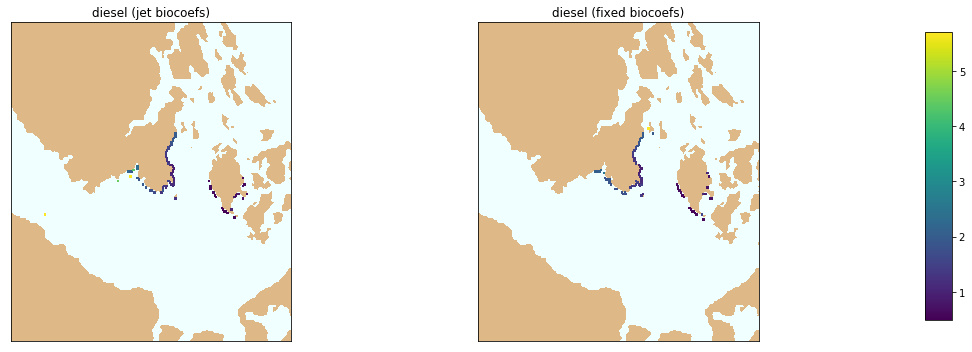

In [31]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

# add land mask to ax1 and ax2
viz_tools.plot_land_mask(axs[0],'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')
viz_tools.plot_land_mask(axs[1],'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')
#viz_tools.plot_land_mask(axs[2],'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')
#viz_tools.plot_land_mask(axs[3],'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')

# add beaching time scales
mappable = axs[0].pcolormesh(diesel_jetbio_time_asnum)
mappable = axs[1].pcolormesh(diesel_biofixed_time_asnum)
#mappable = axs[2].pcolormesh(diesel_bio_time_asnum)
#mappable = axs[3].pcolormesh(gas_fingas_time_asnum)

axs[0].set_title("diesel (jet biocoefs)")
axs[1].set_title("diesel (fixed biocoefs)")
#axs[2].set_title("diesel (jet OWtension)")
#axs[3].set_title("gas (fingas)")


for a in axs:
    a.set_facecolor('azure')
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
    viz_tools.set_aspect(a)
    a.set_xlim(100,300) #change this to set x axis limits
    a.set_ylim(200,400) #change this to set y axis limits
    
plt.tight_layout();

#[left, bottom, width, height]
ax_cbar = fig.add_axes([1.,0.1,0.025,.8])
cbar = plt.colorbar(mappable, cax=ax_cbar, orientation='vertical')
plt.style.available[23]

In [24]:
# Check to see if there are any values in the diesel crude test case
is_crude_data = np.nansum(diesel_crude_time_asnum)
is_crude_data

129.79166666666666

TypeError: set_xticklabels() missing 1 required positional argument: 'labels'

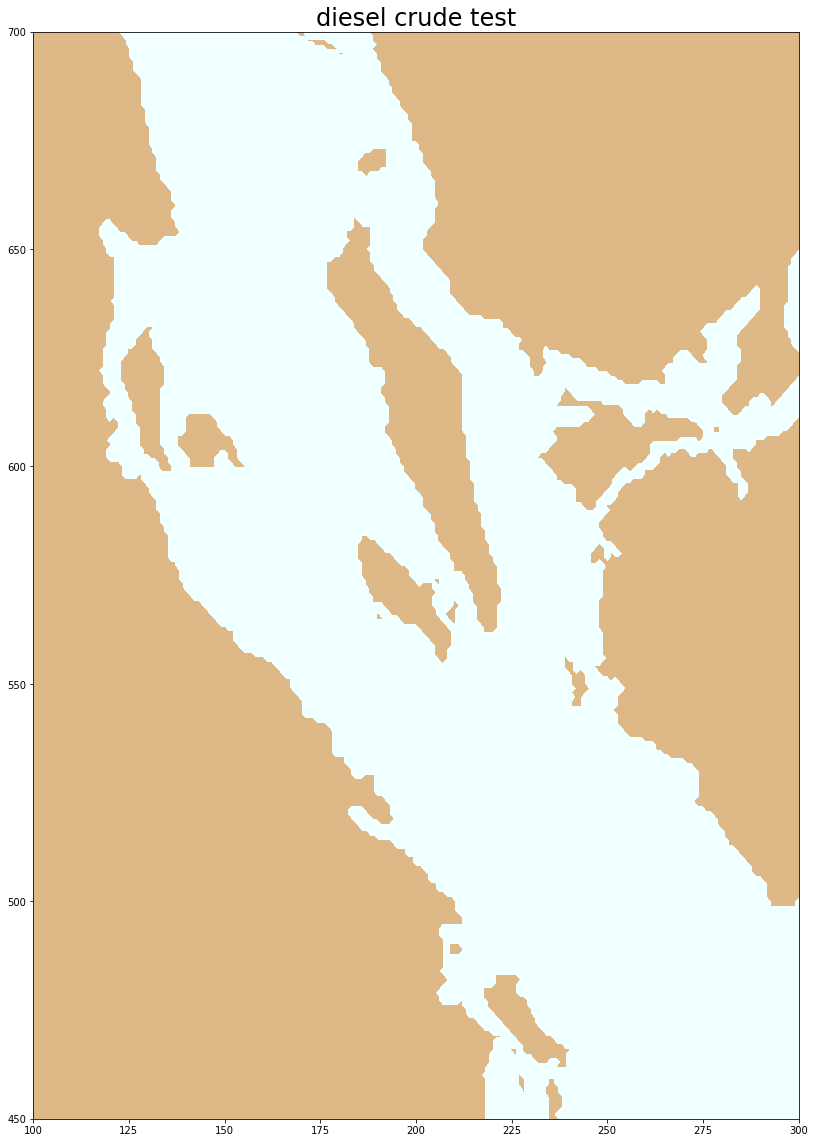

In [25]:
fig, axs = plt.subplots(1,1, figsize=(40,20))

# add land mask to ax1 and ax2
viz_tools.plot_land_mask(axs,'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')

# add beaching time scales
mappable = axs.pcolormesh(diesel_crude_time_asnum,)

axs.set_title("diesel crude test", fontsize=24)

axs.set_facecolor('azure')
#axs.get_xaxis().set_visible(False)
#axs.get_yaxis().set_visible(False)
viz_tools.set_aspect(axs)
axs.set_xlim(100,300) #change this to set x axis limits
axs.set_ylim(450,700) #change this to set y axis limits
axs.set_xticklabels(fontdict={'fontsize':24})    
plt.tight_layout();

ax_cbar = fig.add_axes([1.02,0.11,0.025,.78])
cbar = plt.colorbar(mappable, cax=ax_cbar, orientation='vertical')

### The beaching timescale problem doesn't appear to be an issue to `Crude` vs. `Refined` OilType as there is oil beaching in water points for this case too, in which OilType is set to `crude`


## Plotting up mass balance for diesel crude case

In [ ]:
with open('/Users/rmueller/Projects/MIDOSS/results/DieselTest/resOilOutput.sro', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]
    header = all_data[4]
    
# Order header into list array by splitting up string
header_arr = []
header_arr = header.split(' ')
# Remove emtpy entries from list
header_arr = np.asarray([x for x in header_arr if x != ''])
header_arr

In [ ]:
# crude diesel case
file_in = '/Users/rmueller/Projects/MIDOSS/results/DieselTest/resOilOutput.sro'
data2D = np.genfromtxt(file_in, skip_header=6, skip_footer=4)

# Bunker-C case
file_in_r = '/Users/rmueller/Projects/MIDOSS/results/HeavyFloater/SOG_21nov17-28nov17_general_evap_fix2/resOilOutput.sro'
data2D_r = np.genfromtxt(file_in_r, skip_header=6, skip_footer=4)
nrows,ncols = data2D.shape
nrows_r, ncols_r = data2D_r.shape

In [ ]:
# define structure of structured array
dtype = [('Header',(np.str_,22)),('Values', np.float64)]

# create index list for for-loop over columns
header_range = range(header_arr.size)
data_range = range(nrows)

# Assign 2D data and header strings to structured array
massbalance = np.array([[(header_arr[hdr_index], data2D[data_index, hdr_index]) for hdr_index in header_range] for data_index in data_range], dtype=dtype)

# bunker-C case (_r)
massbalance_r = np.array([[(header_arr[hdr_index], data2D_r[data_index, hdr_index]) for hdr_index in header_range] for data_index in range(nrows_r)], dtype=dtype)

In [ ]:
[data_len, ncols] = massbalance.shape
[data_len_r, ncols] = massbalance_r.shape
i_mevaporated = 15
i_mdispersed  = 18
i_mdissolved  = 24
i_mbio        = 37
i_voloilbeached = 8
i_volumebeached = 9
i_volumeoil     = 10
i_volume        = 11
i_vwatercontent = 34
i_msedimented   = 21
i_mwatercontent = 33
i_density   = 35
i_viscosity = 36 
i_area = 12
i_theorical_area = 13
# analyte mass (I thought this was dissolved but the numbers are more reflective of dispersed)
i_analytemass0 = 42
i_analytemass1 = 43
i_analytemass2 = 44
i_analytemass3 = 45
i_analytemass4 = 46
# biodegredation
i_bio0 = 47
i_bio0 = 48
i_bio0 = 49
i_bio0 = 50
i_bio0 = 51

In [ ]:
# plot data for diesel crude case
plot_data = [15,18,24,37]
header_arr[plot_data]
#plt.plot([data2D[range(191), data_index] for data_index in plot_data])
plt.plot(data2D[range(data_len), plot_data[0]])
plt.plot(data2D[range(data_len), plot_data[1]])
plt.plot(data2D[range(data_len), plot_data[2]])
plt.plot(data2D[range(data_len), plot_data[3]])
plt.title('Diesel Crude case')
plt.ylabel('Mass (Tonnes)')
plt.xlabel('Time after oil release (hours) ')
plt.legend(['Evaporated', 'Dispersed','Disolved','Biodegraded'])
#plt.savefig('EvaporativeExposure_massbalance.png')

In [ ]:
# plot data for diesel crude case
plot_data = [15,18,24,37]
header_arr[plot_data]
#plt.plot([data2D[range(191), data_index] for data_index in plot_data])
plt.plot(data2D_r[range(data_len_r), plot_data[0]])
plt.plot(data2D_r[range(data_len_r), plot_data[1]])
plt.plot(data2D_r[range(data_len_r), plot_data[2]])
plt.plot(data2D_r[range(data_len_r), plot_data[3]])
plt.title('Bunker-C case')
plt.ylabel('Mass (Tonnes)')
plt.xlabel('Time after oil release (hours) ')
plt.legend(['Evaporated', 'Dispersed','Disolved','Biodegraded'])